In [21]:
#1.1
# 步骤1：导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# 步骤2：读取数据文件
file_path = r'D:\hbh\200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
ds = xr.open_dataset(file_path)

# 步骤3：提取原始数据和月份信息
xch4_data = ds['xch4'].values  # 形状: (210, 36, 72)
months = ds.time.dt.month.values
lons = ds.lon.values
lats = ds.lat.values

# 步骤4：将数据从摩尔分数转换为ppb单位
xch4_ppb = xch4_data * 1e9  # 1 ppb = 1e-9

正在计算全球平均时间序列...


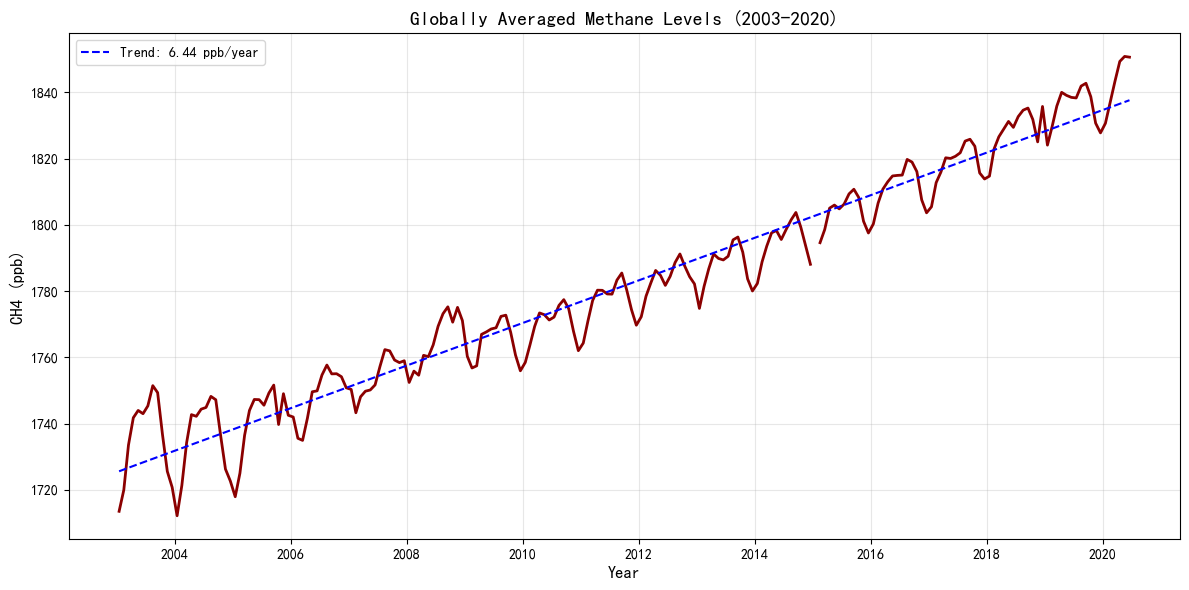


全球平均甲烷时间序列统计:
起始值 (2003年): 1713.5 ppb
结束值 (2020年): 1850.7 ppb
总增长: 137.2 ppb
年平均增长率: 7.8 ppb/year
2003年平均: 1735.4 ppb
2004年平均: 1735.2 ppb
2005年平均: 1741.3 ppb
2006年平均: 1748.4 ppb
2007年平均: 1754.3 ppb
2008年平均: 1765.2 ppb
2009年平均: 1764.7 ppb
2010年平均: 1769.9 ppb
2011年平均: 1777.1 ppb
2012年平均: 1783.7 ppb
2013年平均: 1787.6 ppb
2014年平均: 1795.1 ppb
2015年平均: 1803.9 ppb
2016年平均: 1811.8 ppb
2017年平均: 1818.5 ppb
2018年平均: 1829.1 ppb
2019年平均: 1835.6 ppb
2020年平均: 1843.7 ppb


In [22]:
# 1.2 计算全球平均甲烷时间序列
# =============================================================================

# 步骤1：计算全球平均（考虑纬度权重）
print("正在计算全球平均时间序列...")

# 创建纬度权重（cos(lat)，因为网格面积随纬度变化）
lat_weights = np.cos(np.deg2rad(lats))
# 将权重扩展到与数据相同的维度
# weights = np.ones((36, 72)) * lat_weights[:, np.newaxis]
weights_2d = lat_weights[:, np.newaxis]  # 形状 (36, 1)
# 计算每个时间点的全球加权平均
global_avg_ts = np.zeros(210)  # 210个时间点
time_dates = ds.time.values  # 获取时间坐标

for i in range(210):
    # 获取当前时间点的数据
    current_data = xch4_ppb[i]
    # 创建有效数据掩码
    valid_mask = current_data < 10000
    # 应用掩码，无效数据设为NaN
    masked_data = np.where(valid_mask, current_data, np.nan)
    # # 计算加权平均（忽略NaN值）
    # if np.any(~np.isnan(masked_data)):
    #     global_avg_ts[i] = np.nanmean(masked_data * weights) / np.nanmean(weights)
    # else:
    #     global_avg_ts[i] = np.nan

    # 正确的加权平均计算
    weighted_sum = np.nansum(masked_data * weights_2d)
    # 只对有效数据计算权重和
    valid_weights = np.where(~np.isnan(masked_data), weights_2d, 0)
    weight_sum = np.sum(valid_weights)
    
    if weight_sum > 0:
        global_avg_ts[i] = weighted_sum / weight_sum
    else:
        global_avg_ts[i] = np.nan

# 步骤2：绘制时间序列图
plt.figure(figsize=(12, 6))
plt.plot(time_dates, global_avg_ts, linewidth=2, color='darkred')
plt.title('Globally Averaged Methane Levels (2003-2020)', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('CH4 (ppb)', fontsize=12)
plt.grid(True, alpha=0.3)

# 计算线性趋势
valid_indices = ~np.isnan(global_avg_ts)
if np.sum(valid_indices) > 0:
    x = np.arange(len(global_avg_ts))[valid_indices]
    y = global_avg_ts[valid_indices]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(time_dates[valid_indices], p(x), '--', color='blue', 
             linewidth=1.5, label=f'Trend: {z[0]*12:.2f} ppb/year')

plt.legend()
plt.tight_layout()
plt.show()

# 步骤3：输出统计信息
print("\n全球平均甲烷时间序列统计:")
print(f"起始值 (2003年): {global_avg_ts[0]:.1f} ppb")
print(f"结束值 (2020年): {global_avg_ts[-1]:.1f} ppb")
print(f"总增长: {global_avg_ts[-1] - global_avg_ts[0]:.1f} ppb")
print(f"年平均增长率: {(global_avg_ts[-1] - global_avg_ts[0]) / 17.5:.1f} ppb/year")

# 计算年平均值（用于验证）
annual_avg = []
years = range(2003, 2021)
for year in years:
    year_mask = ds.time.dt.year.values == year
    if np.sum(year_mask) > 0:
        year_avg = np.nanmean(global_avg_ts[year_mask])
        annual_avg.append(year_avg)
        print(f"{year}年平均: {year_avg:.1f} ppb")